# Лабораторная работа №1.6

In [27]:
import numpy as np
import mmh3
from datasketch import MinHash as RefMinHash
import matplotlib.pyplot as plt
from tqdm import tqdm

class MinHash:
    def __init__(self, num_hashes=128, seed=42):
        self.num_hashes = num_hashes
        self.seed = seed
        self.hash_seeds = [int(s) for s in np.arange(num_hashes) + seed]
        
    def create_shingles(self, text, n=3, word_level=False):
        """Создание шинглов (словесных или символьных)"""
        if word_level:
            return set(text.lower().split())
        return set(text[i:i+n] for i in range(len(text)-n+1))
    
    def compute_signature(self, shingles):
        """Вычисление сигнатуры"""
        signature = np.full(self.num_hashes, np.inf)
        for shingle in shingles:
            hashes = np.array([mmh3.hash(shingle, seed=s) for s in self.hash_seeds])
            signature = np.minimum(signature, hashes)
        return signature
    
    def estimate_jaccard(self, sig1, sig2):
        """Оценка сходства Жаккара"""
        return np.mean(sig1 == sig2)

# Анализ

Оценка сходства Жаккара: 0.66
Хэш-функций: 16, FP rate: 0.0000
Хэш-функций: 32, FP rate: 0.0000
Хэш-функций: 64, FP rate: 0.0000
Хэш-функций: 128, FP rate: 0.0000
Хэш-функций: 256, FP rate: 0.0000
Хэш-функций: 512, FP rate: 0.0000


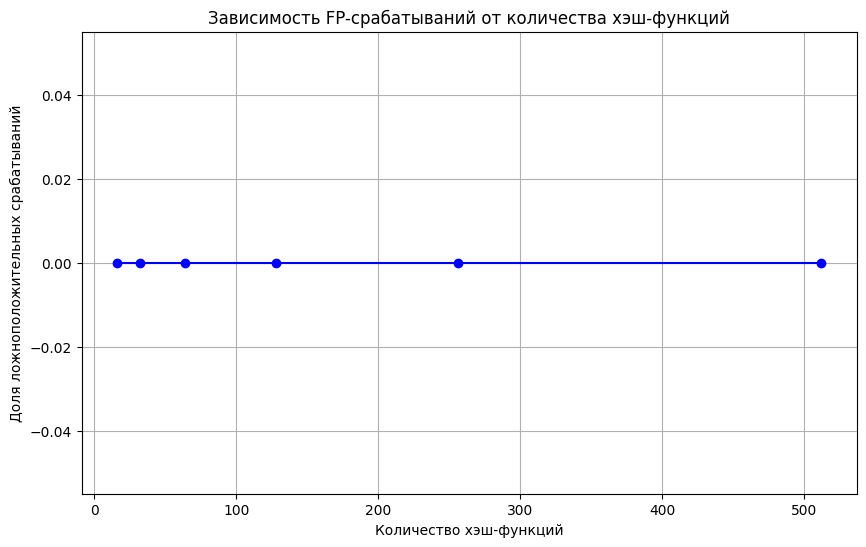

Порог: 0.1, FP rate: 0.0000
Порог: 0.2, FP rate: 0.0000
Порог: 0.3, FP rate: 0.0000
Порог: 0.4, FP rate: 0.0000
Порог: 0.5, FP rate: 0.0000
Порог: 0.6, FP rate: 0.0000
Порог: 0.7, FP rate: 0.0000
Порог: 0.8, FP rate: 0.0000
Порог: 0.9, FP rate: 0.0000


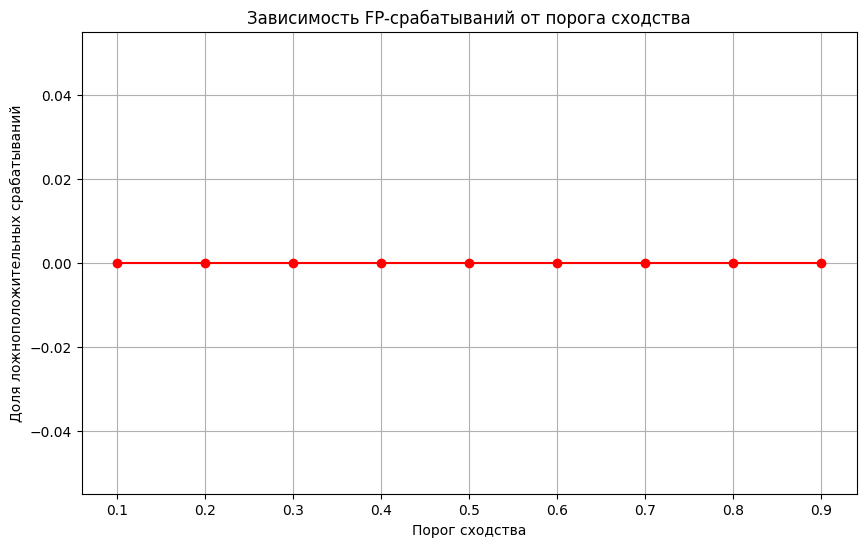

In [28]:
def generate_random_string(length=20):
    return ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), size=length))

def false_positive_test(num_tests=1000, string_length=20, similarity_threshold=0.2, **minhash_params):
    minhash = MinHash(**minhash_params)
    false_positives = 0
    
    for _ in range(num_tests):
        # Генерируем две совершенно разные случайные строки
        s1 = generate_random_string(string_length)
        s2 = generate_random_string(string_length)
        
        # Создаем шинглы
        shingles1 = minhash.create_shingles(s1)
        shingles2 = minhash.create_shingles(s2)
        
        # Вычисляем сигнатуры
        sig1 = minhash.compute_signature(shingles1)
        sig2 = minhash.compute_signature(shingles2)
        
        # Оцениваем сходство
        estimated_sim = minhash.estimate_jaccard(sig1, sig2)

        # Проверяем на ложноположительное срабатывание
        if estimated_sim >= similarity_threshold:
            false_positives += 1
    
    return false_positives / num_tests

def analyze_false_positives():
    # Тестируем разное количество хэш-функций
    hash_counts = [16, 32, 64, 128, 256, 512]
    fp_rates = []
    
    for num_hashes in hash_counts:
        fp_rate = false_positive_test(num_hashes=num_hashes, similarity_threshold=0.2)
        fp_rates.append(fp_rate)
        print(f"Хэш-функций: {num_hashes}, FP rate: {fp_rate:.4f}")
    
    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(hash_counts, fp_rates, 'bo-')
    plt.xlabel('Количество хэш-функций')
    plt.ylabel('Доля ложноположительных срабатываний')
    plt.title('Зависимость FP-срабатываний от количества хэш-функций')
    plt.grid(True)
    plt.show()
    
    # Тестируем разные пороги сходства
    thresholds = np.linspace(0.1, 0.9, 9)
    fp_rates_thresh = []
    
    for thresh in thresholds:
        fp_rate = false_positive_test(num_hashes=128, similarity_threshold=thresh)
        fp_rates_thresh.append(fp_rate)
        print(f"Порог: {thresh:.1f}, FP rate: {fp_rate:.4f}")
    
    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fp_rates_thresh, 'ro-')
    plt.xlabel('Порог сходства')
    plt.ylabel('Доля ложноположительных срабатываний')
    plt.title('Зависимость FP-срабатываний от порога сходства')
    plt.grid(True)
    plt.show()

# Пример использования
minhash = MinHash(num_hashes=128)

text1 = "MinHash is a probabilistic data structure for estimating the similarity between sets" 
text2 = "MinHash is a probabilistic data structure that helps estimate similarity between datasets"

shingles1 = minhash.create_shingles(text1)
shingles2 = minhash.create_shingles(text2)

sig1 = minhash.compute_signature(shingles1)
sig2 = minhash.compute_signature(shingles2)

similarity = minhash.estimate_jaccard(sig1, sig2)
print(f"Оценка сходства Жаккара: {similarity:.2f}")

# Анализ ложноположительных срабатываний
analyze_false_positives()

In [31]:
def compare_implementations(text1, text2, n=3, word_level=False):
    """Сравнение нашей реализации с эталонной"""
    myMinHash = MinHash()
    shingles1 = myMinHash.create_shingles(text1, n=n, word_level=word_level)
    shingles2 = myMinHash.create_shingles(text2, n=n, word_level=word_level)
    sig1 = myMinHash.compute_signature(shingles1)
    sig2 = myMinHash.compute_signature(shingles2)
    custom_sim = myMinHash.estimate_jaccard(sig1, sig2)
    
    # Эталонная реализация
    ref_mh1 = RefMinHash()
    ref_mh2 = RefMinHash()
    
    for shingle in shingles1:
        ref_mh1.update(shingle.encode('utf-8'))
    for shingle in shingles2:
        ref_mh2.update(shingle.encode('utf-8'))
        
    ref_sim = ref_mh1.jaccard(ref_mh2)
    
    return custom_sim, ref_sim

def generate_random_string(length=20):
    """Генерация случайной строки"""
    chars = np.array(list('абвгдеёжзийклмнопрстуфхцчшщъыьэюя'))
    return ''.join(np.random.choice(chars, size=length))

# Пример сравнения конкретных строк
text1 = "привет как дела"
text2 = "как привет дела"

print("Сравнение с учетом порядка (символьные шинглы):")
custom_sim, ref_sim = compare_implementations(text1, text2, word_level=False)
print(f"Наша реализация: {custom_sim:.2f}, Эталон: {ref_sim:.2f}")

print("\nСравнение без учета порядка (словесные шинглы):")
custom_sim, ref_sim = compare_implementations(text1, text2, word_level=True)
print(f"Наша реализация: {custom_sim:.2f}, Эталон: {ref_sim:.2f}")


Сравнение с учетом порядка (символьные шинглы):
Наша реализация: 0.69, Эталон: 0.51

Сравнение без учета порядка (словесные шинглы):
Наша реализация: 1.00, Эталон: 1.00
